In [1]:
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path
sys.path.append('/Users/david/projects/vortexa/analytics')

Generate some fake non-stationary time series data.

The time series includes trend, seasonal, and noise components.

In [2]:
ndays = 100
time = np.arange(ndays)
noise = 0.1
trend = 0.1*time
seasonal = 1* np.sin(2*np.pi* 1/30 * time)

flows = trend + seasonal + np.random.randn(ndays)*noise

Now we begin attempting to forecast beyond the final data point. First define the length of the forecast (try 30 days).

In [3]:
forecast = 30

time_total        = np.arange(ndays + forecast)
flows_total       = np.zeros(ndays + forecast)
uncertainty_total = np.zeros(ndays + forecast)

The thing to remember about forecasting is, the better the forecast gets, the less generaly it can be applied (in general). The most general forecast would be a global mean. The 1$\sigma$ (or 68 percentile) confidence limit for the global mean is just the standard deviation.

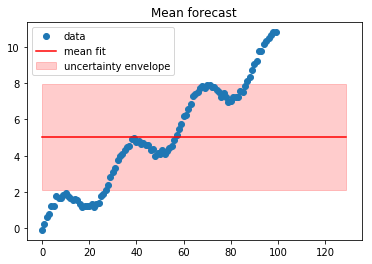

In [4]:
flows_total[:] = np.mean(flows)
uncertainty_total[:] = np.std(flows)


#plot the result
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time,flows,marker='o',ls='',label='data')
ax1.plot(time_total,flows_total,label='mean fit',color='r')
ax1.fill_between(time_total,flows_total - uncertainty_total, flows_total + uncertainty_total,
                 label='uncertainty envelope',alpha = 0.2,color='r')
ax1.set_title('Mean forecast')
plt.legend()
plt.show()

The next, more specific, technique would be to fit a straight line.

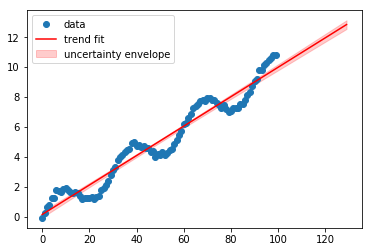

In [5]:
from prediction_functions.polyfit import *
output = fit(time, flows, order=1, xgrid=time_total, confidence=0.3173, nits=20000, figure_title='', verbose=False)
yg_med, yg_lo, yg_hi, cov, cisq, cisq_red, bic, aic, rmd, r2 = output


#plot the result
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time,flows,marker='o',ls='',label='data')
ax1.plot(time_total,yg_med,label='trend fit',color='r')
ax1.fill_between(time_total,yg_lo,yg_hi,label='uncertainty envelope',color='r',alpha=0.2)
plt.legend()
plt.show()

These methods, while general, do not allow fitting seasonal components. For that, we need a fourier based approach. Fouriers theorem tells us that any signal can be decomposed into a sum of sine and cosine waves.

$f(t) = \sum_{k=0}^{k=k_\mathrm{max}} S_k \sin \left( 2 \pi f_k t \right) + C_k \cos \left( 2 \pi f_k t \right)$

where, for a time series of length $T$, the 'fittable' frequencies take the form

$f_k = k \frac{1}{2} T$ where $k_\mathrm{min} = 0$ and $k_\mathrm{max} = \frac{T}{\Delta t}$.

The upper frequency limit is known as the 'Nyquist Frequency' and cannot be exceeded using standard methods as all frequencies abnove this are degenerate parameters. 

Lets combine the fourier method with the polynomial trend fits (just to say I did this before the facebook prophet algorithm came out... just saying).

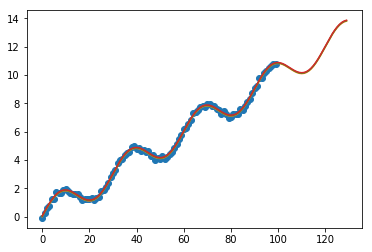

In [6]:
from prediction_functions.rw_poly_combined import *

output = rw(time,flows,si = np.ones(ndays)*noise, tgi = time_total,custom_freqs=np.array([1./30]))
tgrid,ygrid,frequencies,Ck,Sk,poly_coef,rc = output
yg_lo,yg_med,yg_hi = ygrid[:,0],ygrid[:,1],ygrid[:,2]


#plot the result
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time,flows,marker='o',ls='',label='data')
ax1.plot(time_total,ygrid,label='trend fit')
ax1.fill_between(time_total,yg_lo,yg_hi)
plt.show()